[![Open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Its-Shivanshu-Sharma/AdversarialAttacks/blob/main/Adversarial_Attacks.ipynb)

# Adversarial Attacks on Neural Networks

---

## Table of Contents:
- ### [Installing & Importing packages, libraries, etc](#installing-&-importing-packages,-libraries,-etc)
- ### [Fetching & preparing the Dataset](#fetching-&-preparing-the-dataset)

<a name="installing-&-importing-packages,-libraries,-etc"></a>

---
## Installing & Importing packages, libraries, etc

### Installing packages

In [ ]:
%%bash
pip3 install -qq torch==1.10.2+cu113 torchvision==0.11.3+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

### Importing packages, libraries, etc

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [ ]:
# Setting setting the seed for the RNG (Random Number Generator)
# for reproducibility
torch.manual_seed(1234)

<a name="fetching-&-preparing-the-dataset"></a>

---
## Fetching & preparing the Dataset

We'll creating a model for binary classification using the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In [ ]:
%%bash
# Create a new directory to store the dataset
mkdir pets_dataset
cd pets_dataset
wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
tar -xf images.tar.gz
tar -xf annotations.tar.gz

mkdir: cannot create directory ‘pets_dataset’: File exists


In [ ]:
from pathlib import Path

In [ ]:
path = Path("/content/pets_dataset")

In [ ]:
def ls(path):
    for f in path.iterdir():
        print(f"{'d' if f.is_dir() else 'f': <4}{f}")

In [ ]:
ls(path)

d   /content/pets_dataset/annotations
f   /content/pets_dataset/annotations.tar.gz
d   /content/pets_dataset/images
f   /content/pets_dataset/annotations.tar.gz.1
f   /content/pets_dataset/images.tar.gz
f   /content/pets_dataset/images.tar.gz.1


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(
    path / "annotations" / "list.txt",
    skiprows=6,
    header=None,
    names=["file_name", "class_id", "species", "breed_id"],
    sep=" ",
)
df.head()

,file_name,class_id,species,breed_id
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [ ]:
df = df.loc[:, ["file_name", "species"]]
df.head()

,file_name,species
0,Abyssinian_100,1
1,Abyssinian_101,1
2,Abyssinian_102,1
3,Abyssinian_103,1
4,Abyssinian_104,1


#### Change the labels (i.e. `species`) such that:
`Cat = 0` & `Dog = 1`

In [ ]:
species_mapping = {
    1: 0,
    2: 1,
}

In [ ]:
df.loc[:, "species"] = df.loc[:, "species"].apply(species_mapping.get)

In [ ]:
df.head()

,file_name,species
0,Abyssinian_100,0
1,Abyssinian_101,0
2,Abyssinian_102,0
3,Abyssinian_103,0
4,Abyssinian_104,0


In [ ]:
def train_val_split(data, train_sz=None, val_sz=None):
    """Function to randomly split data into training & validation sets
    Parameters:
        data (pandas.DataFrame) - dataframe containing the annotations for the
                                    images
        train_sz (float) - fraction of data to be allocated to training set
        val_sz (float) - fraction of data to be allocated to test set
                            (`test_sz` is ignored if `train_sz` is not `None`)

    Returns:
        A tuple containing Dataframes for the training and validation sets,
        i.e. returns `(train_set, val_set)`.
    """
    size = len(data)
    # Calculate length of the training set
    if train_sz:
        train_len = int(train_sz * size)
    elif val_sz:
        train_len = size - int(val_sz * size)

    # Randomly generate training and validation datasets
    idxs = torch.randperm(size)
    train_set = data.iloc[idxs[:train_len], :].reset_index(drop=True)
    val_set = data.iloc[idxs[train_len:], :].reset_index(drop=True)

    return train_set, val_set

In [ ]:
train_set, val_set = train_val_split(df, train_sz=0.8)

In [ ]:
train_set.head()

,file_name,species
0,staffordshire_bull_terrier_174,1
1,beagle_73,1
2,Abyssinian_192,0
3,american_pit_bull_terrier_93,1
4,american_pit_bull_terrier_119,1


#### Create `Dataset` objects for the training & validations sets

In [ ]:
import os

from torchvision.io import read_image
from torchvision.transforms import Resize

In [ ]:
class PetsDataset(Dataset):
    """Custom defined Dataset subclass for working with the IIIT-Pets Dataset"""

    def __init__(
        self,
        annotations,
        img_dir,
        img_format="jpg",
        transform=None,
        target_transform=None,
    ):
        """Parameters:
        annotations (pandas.DataFrame) - dataframe containing the annotations
        img_dir (str or Path object) - path to directory containing images
        img_format (str: default = 'jpg') - format of the images
        transform (callable; optional) - Tranformation to apply to images
        target_transform (callable; optional) - Transformation to apply to
                                                target labels
        """
        self.annotations = annotations
        self.img_dir = img_dir
        self.img_format = img_format
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        file_name = self.annotations.iloc[index, 0] + "." + self.img_format
        img_file = os.path.join(self.img_dir, file_name)
        image = read_image(img_file)
        label = self.annotations.iloc[index, 1]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### **Note:** Some images have an additional `alpha` channel for transparency.<br>This will cause problems, hence, we will simply remove this additional channel using the `resize_remove` tranform on the images.

In [ ]:
def resize_remove(img_size):
    """This function will resize the image to the passed size using `torchvision.transforms.Resize`
    and will keep only the first `img_size[0]` number of channels.

    Parameters:
        img_size (tuple or array-like) - specifies the size
                                        (channels, height, width) to which the
                                        image must be resized
    Returns:
        a callable that will resize the image & remove extra channels
    """
    resizer = Resize(img_size[1:])

    def transform(img):
        return resizer(img[: img_size[0], :, :])

    return transform

In [4]:
# Define the image size in (C, H, W) format
img_size = (3, 150, 150)

In [ ]:
train_data = PetsDataset(
    train_set, img_dir=path / "images", transform=resize_remove(img_size)
)
val_data = PetsDataset(
    val_set, img_dir=path / "images", transform=resize_remove(img_size)
)

### Visualizing the Data

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def viz_data(data, label_map, n_rows=3, n_cols=3):
    """Function to display n_rows*n_cols number of images of the Dataset
    Parameters:
        data (Dataset or its subclass) - data which has to be visualized
        label_map (dict) - mapping from int to labels for the classes
        n_rows (int) - no. of rows of images to display
        n_cols (int) - no. of columns of images to display
    """
    figure = plt.figure(figsize=(8, 8))
    # Randomly choose the images to display from the data
    idxs = torch.randint(high=len(data), size=(n_rows * n_cols,)).tolist()

    for i, idx in enumerate(idxs):
        img, label = data[idx]
        figure.add_subplot(n_rows, n_cols, i + 1)
        plt.title(label_map.get(label))
        plt.axis("off")
        plt.imshow(img.permute((1, 2, 0)))  # change image to (H,W,C) format
    plt.show()

In [ ]:
label_map = {
    0: "Cat",
    1: "Dog",
}

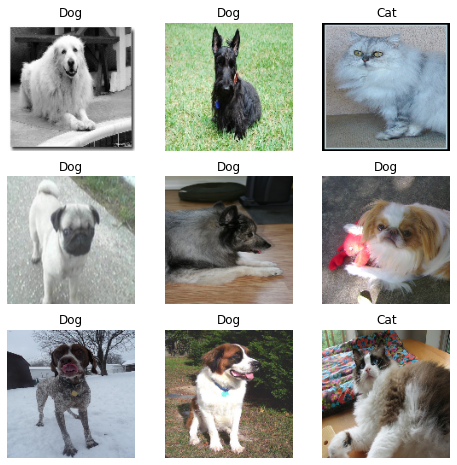

In [ ]:
viz_data(train_data, label_map)

#### Create `DataLoader` objects for the training & validation data

In [ ]:
# define the batch size
bs = 32

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=bs, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=bs, shuffle=True)

<a name="training-a-deep-neural-network-for-binary-classification"></a>

---
## Training a Deep Neural Network for Binary Classification

In this section we will be training a simple `Feed-Forward Neural Network` on our pets dataset.<br> The output of the network will be one of the 2 classes, i.e. `Cat` or `Dog`.

In [1]:
from functools import reduce

from torch.optim.sgd import SGD

In [ ]:
class FeedForwardNetwork(nn.Module):
    """A class defining a simple Feedforward neural network"""

    def __init__(self, img_size):
        """Parameters:
        img_size - dimensions of the input image
        """
        super(Model, self).__init__()
        input_size = reduce(lambda x, y: x * y, img_size)

        self.sequential = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.sequential(x)

In [ ]:
def train_loop(train_dataloader, model, loss_fn, optimizer, device="cpu"):
    """Function to perform the training on the data for one epoch.

    Parameters:
    train_dataloader (DataLoader) - dataloader object for the training data
    model - the model which has to be trained (& used for making predictions)
    loss_fn (function) - loss function to use for calculating the gradients
    optimizer - optimizer to use for updating the parameters of the model
    device (str: default="cpu") - device to use for training the model

    Returns: (tuple)
    Average of training loss taken across all the batches
    """
    model.train()
    avg_loss = 0
    for x, y in train_dataloader:
        x = x.float().to(device)
        y = y.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        pred = model(x)
        # Calculate loss & gradients
        loss = loss_fn(pred, y)
        avg_loss += loss.item()
        loss.backward()
        # Update parameter values
        optimizer.step()
    return avg_loss / len(train_dataloader)

In [ ]:
def val_loop(val_dataloader, model, loss_fn, threshold=0.5, device="cpu"):
    """Function to calculate the loss & accuracy of the model for the validation
    dataset.

    Parameters:
    val_dataloader (DataLoader) - dataloader object for the validation data
    model - model for making the predictions
    loss_fn (function) - loss function to use for calculating the gradients
    threshold (float: default=0.5) - threshold value above which the prediction
                                    will be classified as belonging to class `1`
    device (str: default="cpu") - device to use for inference

    Returns: (tuple)
    Average of validation loss (taken across all the batches) & accuracy of the
    model,
    i.e. tuple of format (average loss, accuracy)
    """
    model.eval()
    avg_loss = 0
    correct = 0
    # Gradient need not be computed for the validation data, hence, computations
    # can be sped up
    with torch.no_grad():
        for x, y in val_dataloader:
            x = x.float().to(device)
            y = y.float().unsqueeze(1).to(device)
            pred = model(x)
            avg_loss += loss_fn(pred, y).item()
            correct += ((pred > threshold) == y).float().sum().item()
    return avg_loss / len(val_dataloader), correct / len(val_dataloader.dataset)

### Create, train & validate model

##### Use `GPU` for training if available else use `CPU`

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device being used: {device}")

Device being used: cuda


In [ ]:
model = Model()
model.to(device);

In [ ]:
n_epochs = 10
lr = 1e-3
optimizer = SGD(model.parameters(), lr)
bce_loss = nn.BCELoss()

In [ ]:
results = pd.DataFrame(
    [],
    columns=["Training Loss", "Validation Loss", "Accuracy"],
    index=pd.Index([], name="Epoch No."),
)
for i in range(n_epochs):
    train_loss = train_loop(train_dataloader, model, bce_loss, optimizer, device=device)
    val_loss, accuracy = val_loop(val_dataloader, model, bce_loss, device=device)
    results.loc[i] = [train_loss, val_loss, accuracy]

In [ ]:
results

,Training Loss,Validation Loss,Accuracy
Epoch No.,,,
0,32.011169,32.463768,0.67551
1,32.200349,32.441123,0.67551
2,32.240223,32.454710,0.67551
3,32.206994,32.445652,0.67551
4,32.193703,32.454710,0.67551
5,32.233578,32.441123,0.67551
6,32.220286,32.454710,0.67551
7,32.213640,32.454710,0.67551
8,32.187057,32.450181,0.67551
